In [1]:
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# GPU settings
gpu_index = 0
if gpu_index >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_index >= 0 else np

# 車輪型ロボットモデル（対向2輪型）

In [3]:
class CartLayer:
    def __init__(self,batchsize=1):
        self.cart_num = batchsize
        self.pos = Variable(np.zeros( (batchsize,3), dtype=np.float32))
        self.path = np.zeros( (1,batchsize,3),dtype=float)

    def move(self,param):
        if len(param) == self.cart_num:
            dx = F.reshape(param[:,0] * F.cos(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dy = F.reshape(param[:,0] * F.sin(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dth = F.reshape(param[:,1], (self.cart_num,1))
            D = F.concat((dx,dy),axis=1)
            D = F.concat((D,dth),axis=1)
            self.pos = self.pos + D
            self.path = np.vstack([self.path,[self.pos.data]])
            return self.pos
        else:
            print 'len(param) != cart_num'
            return -1

# 連続で動く
def calc_car_pos(cart_layer, y):
    for step in range(len(y[0])):
        cart_layer.move(y[:,step])
    # print car.path.shape  # (4step, 50batch, 3x-y-th)
    # print car.pos.data.shape  # (50batch, 3x-y-th)
    return cart_layer.pos

# 経路の描画

In [4]:
def plot_path(cart_path,target):
    path = cart_path[:,0,:]
    print path
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   ,scale_units='xy', angles='xy', scale=1,color="blue")
    plt.scatter(target[0],target[1],c="yellow",s=500,marker="*")
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.axis('scaled')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.grid()
    plt.show()

[[0.         0.         0.        ]
 [0.86602539 0.5        0.52359879]
 [1.36602533 1.36602545 1.04719758]
 [1.36602533 2.36602545 1.57079637]]


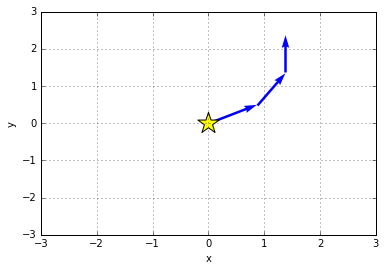

[[[0.         0.         0.        ]]

 [[0.86602539 0.5        0.52359879]]

 [[1.36602533 1.36602545 1.04719758]]

 [[1.36602533 2.36602545 1.57079637]]]


''

In [5]:
''' sample '''
v_arr = np.array([1.0,1.0,1.0],dtype=np.float32)
w_arr = np.array([30.0,30.0,30.0],dtype=np.float32)
w_arr = w_arr * np.pi/180
y_data = np.vstack((v_arr,w_arr)).T
yV = Variable(np.reshape(y_data,(1,3,2) )) 

sample_cart = CartLayer()
pos = calc_car_pos(sample_cart,yV)
plot_path(sample_cart.path,[0,0])
print sample_cart.path
''''''

# ネットワーク

In [6]:
class Generator(Chain):
    def __init__(self):
        initializer = initializers.HeNormal()
        super(Generator, self).__init__(
            l1=L.Linear(2, 15, initialW=initializer),
            l2=L.Linear(15, 6, initialW=initializer),
        )
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        o = F.reshape(h2,(len(x),3,2))
        return o
    '''
    def get_vw(self,output):
        v = output[0,0:3]
        w = output[0,3:6]
        return v,w
    '''

**入出力を確認**

In [7]:
''' sample
model = Generator()
x_data = np.array([[3,0]],dtype=np.float32)
x = Variable(x_data)
print x_data
y = model(x_data)
print y
'''

' sample\nmodel = Generator()\nx_data = np.array([[3,0]],dtype=np.float32)\nx = Variable(x_data)\nprint x_data\ny = model(x_data)\nprint y\n'

### 2018/10/24　オフィスアワー

---
問題点  
* **（0,0）で動かなければ損失が少ないと学習してしまう**  
    ・極座標系で距離を一定に学習する
    
    
* **optimizers.update() **  
    ・勾配を手動計算する場合は引数不要・勾配リセットも必要  
    ・そうでない場合はloss_functionを引数に渡す

その他  
* **Variable配列の型が違って気持ち悪いので行列演算にしたい**

# 極座標変換

[1, 1]
[1.4142135623730951, 45.0]


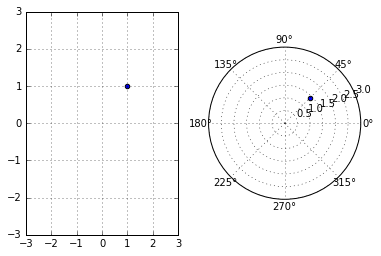

In [8]:
# 極座標変換
def to_polar_coordinate(x,y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    return r,theta
# 直交座標変換
def to_cartesian_coordinate(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x,y

x,y = [1,1]
r,theta = to_polar_coordinate(x,y)
print [x,y]
print [r, theta*180/np.pi]
# 直交系グラフ
ax1 = plt.subplot(1,2,1)
ax1.scatter(x,y)
ax1.axis([-3,3,-3,3])
ax1.grid(True)

# 極座標系グラフ
ax2 = plt.subplot(1,2,2,polar=True)
ax2.scatter(theta,r)
ax2.set_rmax(3)
ax2.grid(True)


# 訓練データの作成

* 極座標系で角度をランダムに指定  

\begin{equation*}
\begin{bmatrix}
r = 2 \\
0 < θ < π
\end{bmatrix}
\end{equation*}

(1000, 2)


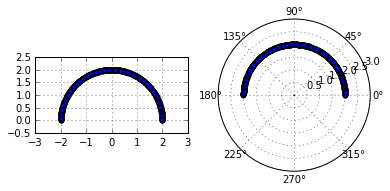

In [9]:
def generate_training_data():
    size = 1000
    r = np.full(size, 2)
    theta = np.random.rand(size) * np.pi
    x,y = to_cartesian_coordinate(r,theta)
    x_data = np.vstack([x,y])
    x_data = x_data.T

    fig1 = plt.subplot(1,2,2,polar=True)
    fig1.scatter(theta,r)
    fig1.set_rmax(3)
    fig1.grid(True)

    fig2 = plt.subplot(1,2,1)
    fig2.scatter(x,y)
    fig2.axis([-3,3,0,3])
    plt.axis('scaled')
    fig2.grid(True)
    
    x_data = np.array(x_data, dtype=np.float32)
    print x_data.shape
    return x_data

x_data = generate_training_data()
# print x_data

# 損失関数

In [10]:
def calc_distance(predpos,truepos):
    px, py, _ = predpos
    tx, ty = truepos
    D = F.sqrt(((tx-px)**2 + (ty-py)**2))
    return D

def velo_diff(v):
    # v (50,3)
    V = np.zeros(len(v),dtype=np.float32)
    for i in range(len(v[0])-1):
        diff = v[:,i] - v[:,i+1]
        V = V + diff*diff
    init_pos = np.zeros(len(v),dtype=np.float32)
    diff = init_pos - v[:,0]
    V = V + diff*diff
    return V
    
def loss_function(y, predpos, truepos):
    ppos = F.reshape(predpos, (3,len(predpos))) #(50,3) -> (3,50)
    tpos = F.reshape(truepos, (2,len(truepos))) #(2,50)
    D = calc_distance(ppos, tpos)
    v = y[:,:,0]
    w = y[:,:,1]
    V = velo_diff(v)
    W = velo_diff(w)
    E = (100*D) # + V + W
    loss = F.mean(E)
    return loss

# 訓練

In [11]:
def train(x_data):
    batch_size = 5
    model = Generator()
    opt = optimizers.Adam()
    gpu_id = -1
    if gpu_id >= 0:
        model.to_gpu(gpu_id)
    train_iter = iterators.SerialIterator(x_data, batch_size)
    opt.setup(model)
    max_epoch = 10
    snapshot = 5
    epoch = 0
    while train_iter.epoch < max_epoch:
        train_batch = np.array(train_iter.next())
        x = Variable(train_batch.astype(np.float32).reshape(len(train_batch),2))
        y = model(x)
        truepos = Variable(train_batch.astype(np.float32).reshape(len(train_batch),2))
        car = CartLayer(len(y))
        predpos = calc_car_pos(car, y)
        loss = loss_function(y,predpos,truepos)
        model.cleargrads()
        loss.backward()
        opt.update(loss_function,y,predpos,truepos)
        epoch = epoch + 1
        if (epoch % snapshot)==0:
            print str(epoch)+": loss "+str(loss.data)
            #plot_path(car.path, target_pos.data)
    return model
model = train(x_data)

5: loss 347.24634
10: loss 180.66536
15: loss 242.11934
20: loss 178.54907
25: loss 315.87076
30: loss 211.1359
35: loss 338.19986
40: loss 291.85046
45: loss 231.8221
50: loss 230.11426
55: loss 269.39957
60: loss 213.69719
65: loss 245.8503
70: loss 236.47227
75: loss 164.4775
80: loss 274.497
85: loss 274.7609
90: loss 261.04132
95: loss 244.01445
100: loss 266.02548
105: loss 243.96646
110: loss 248.61588
115: loss 242.76602
120: loss 234.16728
125: loss 223.76396
130: loss 174.63727
135: loss 155.85057
140: loss 172.43567
145: loss 223.05016
150: loss 208.1363
155: loss 186.54741
160: loss 156.1956
165: loss 138.39134
170: loss 158.6565
175: loss 177.90709
180: loss 205.7064
185: loss 167.25417
190: loss 120.25176
195: loss 187.15501
200: loss 119.19958
205: loss 163.12537
210: loss 185.91486
215: loss 149.09569
220: loss 182.9893
225: loss 165.76813
230: loss 173.59496
235: loss 151.2606
240: loss 149.70209
245: loss 186.48569
250: loss 224.60997
255: loss 99.82228
260: loss 172.

# 推論

loss: variable(187.31093)
v,w: variable([[[-2.6665735   0.43393293]
           [-0.195762    2.568873  ]
           [ 2.6706011  -2.2714    ]]])
[[ 0.          0.          0.        ]
 [-2.41943336 -1.12114072  0.43393293]
 [-2.22555375 -1.14822268  3.00280595]
 [-0.2379961   0.63551629  0.73140597]]


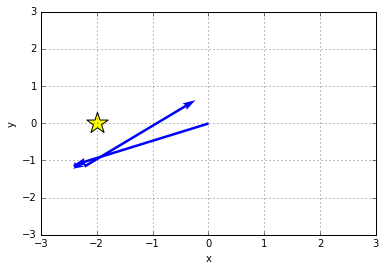

In [12]:
def predict(model, r,theta):
    x,y = to_cartesian_coordinate(r,theta)
    x_data = Variable(np.array([[x,y]],dtype=np.float32))
    o = model(x_data)
    car = CartLayer()
    predpos = calc_car_pos(car, o)
    truepos = Variable(np.array([[x,y]],dtype=np.float32))
    loss = loss_function(o,predpos, truepos)
    print "loss: {}".format(loss)
    print "v,w: {}".format(o)
    # print car.path
    plot_path(car.path, x_data.data[0])

predict(model, 2, np.deg2rad(180.0))

### 2018/11/27
---
* バッチで処理 →　学習回数を増やしてデータを取る
* ネットワークを変える